In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load Dataset
df = pd.read_csv("songs_normalize.csv")


In [ ]:
# Select Features and Target
# Using 'energy' and 'danceability' as features and creating a binary target from 'popularity'
df['popularity_binary'] = (df['popularity'] > df['popularity'].median()).astype(int)
X = df[['energy', 'danceability']].values
y = df['popularity_binary'].values

# Limiting the dataset to the first 500 rows for a concise decision tree
X = X[:500]
y = y[:500]

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pre-Pruning: Decision Tree with Maximum Depth
pre_pruned_tree = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)
pre_pruned_tree.fit(X_train, y_train)

# Post-Pruning: Using Cost-Complexity Pruning
full_tree = DecisionTreeClassifier(criterion='gini', random_state=42)
full_tree.fit(X_train, y_train)

# Get cost-complexity pruning path
ccp_path = full_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = ccp_path.ccp_alphas, ccp_path.impurities

In [ ]:
# Train multiple trees for each alpha (post-pruning)
trees = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(criterion='gini', random_state=42, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train)
    trees.append(tree)

# Evaluate Post-Pruned Trees and Select Best Tree
train_scores = [tree.score(X_train, y_train) for tree in trees]
test_scores = [tree.score(X_test, y_test) for tree in trees]

best_alpha_index = np.argmax(test_scores)
best_post_pruned_tree = trees[best_alpha_index]

# Predictions
pre_pruned_pred = pre_pruned_tree.predict(X_test)
post_pruned_pred = best_post_pruned_tree.predict(X_test)

In [ ]:
# Evaluation Metrics
print("\nPre-Pruned Tree:")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, pre_pruned_pred))
print("\nClassification Report:")
print(classification_report(y_test, pre_pruned_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, pre_pruned_pred))

print("\nPost-Pruned Tree:")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, post_pruned_pred))
print("\nClassification Report:")
print(classification_report(y_test, post_pruned_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, post_pruned_pred))


Pre-Pruned Tree:

Confusion Matrix:
[[67  5]
 [27  1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.93      0.81        72
           1       0.17      0.04      0.06        28

    accuracy                           0.68       100
   macro avg       0.44      0.48      0.43       100
weighted avg       0.56      0.68      0.60       100


Accuracy Score:
0.68

Post-Pruned Tree:

Confusion Matrix:
[[72  0]
 [28  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        72
           1       0.00      0.00      0.00        28

    accuracy                           0.72       100
   macro avg       0.36      0.50      0.42       100
weighted avg       0.52      0.72      0.60       100


Accuracy Score:
0.72


c:\Users\offic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\offic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\offic\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


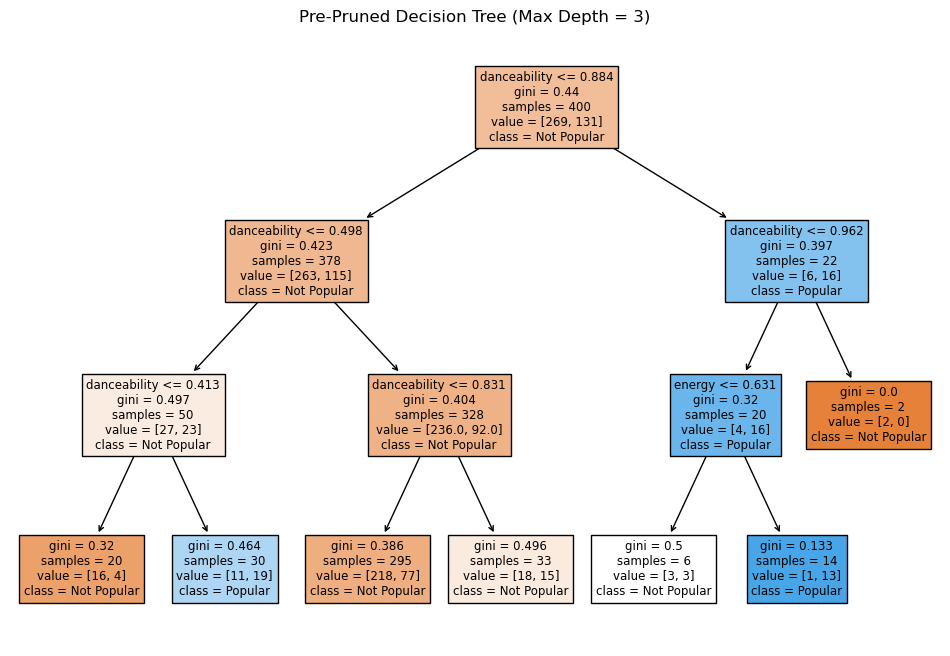

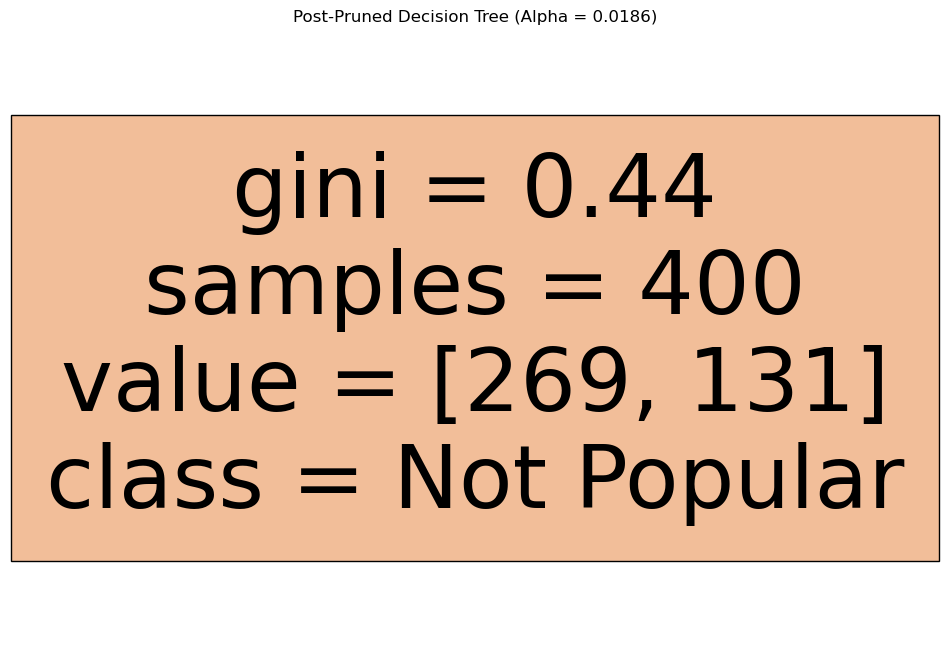

In [ ]:
# Visualize Pre-Pruned Tree
plt.figure(figsize=(12, 8))
plot_tree(pre_pruned_tree, feature_names=['energy', 'danceability'], class_names=['Not Popular', 'Popular'], filled=True)
plt.title("Pre-Pruned Decision Tree (Max Depth = 3)")
plt.show()

# Visualize Post-Pruned Tree
plt.figure(figsize=(12, 8))
plot_tree(best_post_pruned_tree, feature_names=['energy', 'danceability'], class_names=['Not Popular', 'Popular'], filled=True)
plt.title(f"Post-Pruned Decision Tree (Alpha = {ccp_alphas[best_alpha_index]:.4f})")
plt.show()

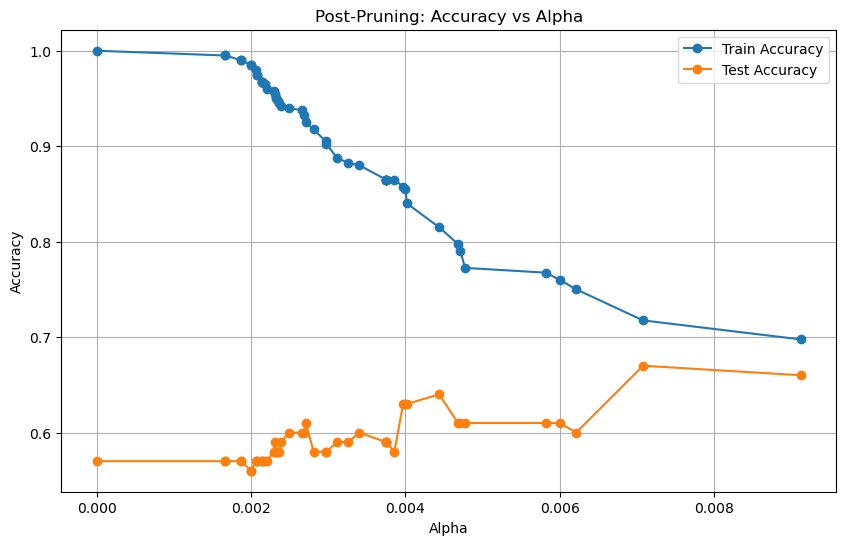

In [ ]:
# Cost-Complexity Pruning Path Plot
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas[:-1], train_scores[:-1], marker='o', label="Train Accuracy")
plt.plot(ccp_alphas[:-1], test_scores[:-1], marker='o', label="Test Accuracy")
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Post-Pruning: Accuracy vs Alpha")
plt.legend()
plt.grid(True)
plt.show()

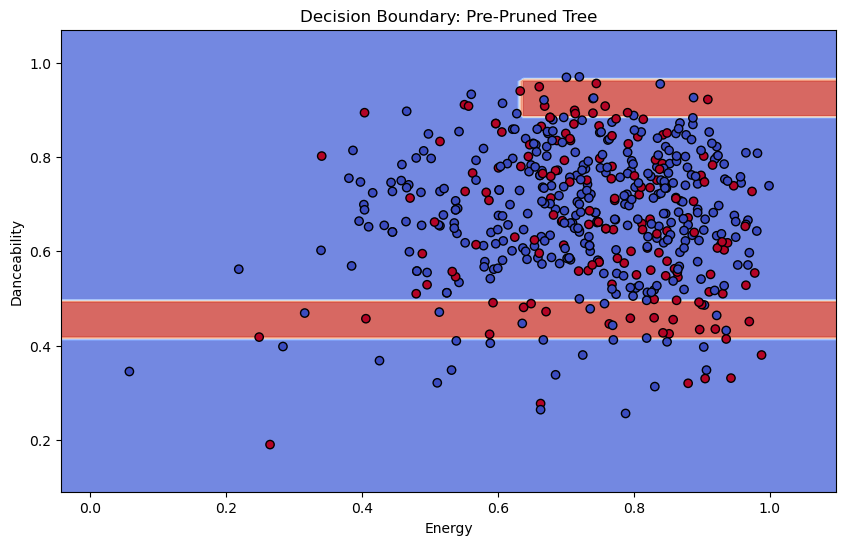

In [ ]:
# Decision Boundary Plot (Pre-Pruned)
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = pre_pruned_tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.coolwarm)
plt.title("Decision Boundary: Pre-Pruned Tree")
plt.xlabel("Energy")
plt.ylabel("Danceability")
plt.show()

In [17]:
print("\n=== Interpretations ===")
# Tree Depth
pre_pruned_depth = pre_pruned_tree.get_depth()
post_pruned_depth = best_post_pruned_tree.get_depth()
    
print(f"1. Pre-Pruned Tree Depth: {pre_pruned_depth}")
print(f"\n2. Post-Pruned Tree Depth: {post_pruned_depth}")
    
# Accuracy Comparison
pre_pruned_accuracy = accuracy_score(y_test, pre_pruned_pred)
post_pruned_accuracy = accuracy_score(y_test, post_pruned_pred)
    
print("\n3. Accuracy Scores:")
print(f"   - Pre-Pruned Accuracy: {pre_pruned_accuracy:.4f}")
print(f"   - Post-Pruned Accuracy: {post_pruned_accuracy:.4f}")
    
print("\n4. Summary:")
print("   - Pre-Pruning restricts tree growth initially, focusing on simplicity.")
print("   - Post-Pruning reduces complexity post-training, balancing accuracy and overfitting.")
print("   - Decision boundaries and classification effectiveness depend on the dataset's nature and feature distribution.")



=== Interpretations ===
1. Pre-Pruned Tree Depth: 3

2. Post-Pruned Tree Depth: 0

3. Accuracy Scores:
   - Pre-Pruned Accuracy: 0.6800
   - Post-Pruned Accuracy: 0.7200

4. Summary:
   - Pre-Pruning restricts tree growth initially, focusing on simplicity.
   - Post-Pruning reduces complexity post-training, balancing accuracy and overfitting.
   - Decision boundaries and classification effectiveness depend on the dataset's nature and feature distribution.


In [ ]:
#Arjun Ajithan Nadukandiyil
#2241119
#6BCA B